In [2]:
import random
import numpy as np
import random
from tqdm import tqdm
import gym
#from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from IPython.display import clear_output
import time

In [3]:
# Setting up the environment
env = gym.make('Taxi-v3')

# Current State
state = env.reset()
print("Current State:", state)

# Number of states
num_states = env.observation_space.n
print("Number of states:", num_states)

# Number of actions
num_actions = env.action_space.n
print("Number of actions that an agent can take:", num_actions)

# Primitive Actions
actions = ["south", "north", "east", "west", "pick", "drop"]

# Example Transitions
rnd_action = random.randint(0, num_actions - 1)
print("Action taken:", actions[rnd_action])
next_state, reward, is_terminal, _ = env.step(rnd_action)
print("Next state:", next_state)
print("Reward received:", reward)
print("Terminal state:", is_terminal)

# Decoded state
decoded_state = env.decode(state)
print("Decoded state:", decoded_state)
print(env.render())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Current State: 1
Number of states: 500
Number of actions that an agent can take: 6
Action taken: east
Next state: 21
Reward received: -1
Terminal state: False
Decoded state: <list_reverseiterator object at 0x78a0822cf640>
None


In [4]:
def stateData(state):
  picdrop = state%20
  pos = state//20
  y = pos//5
  x = pos%5
  drop = picdrop%4
  passenger = picdrop//4
  return x,y,drop,passenger

In [5]:
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    return np.argmax(q_values[state])
  else:
    choice = random.randint(0,q_values.shape[-1]-1)

  return choice

In [8]:
nO = 4 #number of options
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
def Option(env,state,Q,goalNum,eps=0.1,goal = goal):
  optdone = False
  x,y,pas,drop=env.decode(state)

  if (x==goal[goalNum][0] and y==goal[goalNum][1]):
      #print('Reached ',goalNum)
      optdone = True
      if pas == goalNum:
        optact = 4
      elif drop == goalNum:
        optact = 5
      else:
        optact = 1 if (goalNum in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps)
  return [optact,optdone]

'''
Now the new action space will contain
Primitive Actions: ["south", "north", "east", "west","pick","drop"]
Options: ["OptionR","OptionG","OptionY","OptionB"]
Total Actions :["south", "north", "east", "west","pick","drop","OptionR","OptionG","OptionY","OptionB"]
Corresponding to [0,1,2,3,4,5,6,7,8,9]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["south", "north", "east", "west","pick","drop"]\nOptions: ["OptionR","OptionG","OptionY","OptionB"]\nTotal Actions :["south", "north", "east", "west","pick","drop","OptionR","OptionG","OptionY","OptionB"]\nCorresponding to [0,1,2,3,4,5,6,7,8,9]\n'

In [9]:
# Setting up the environment
env = gym.make('Taxi-v3')

# Deterministic option choice parameters
nO = 4  # Assuming you have 4 options
gamma = 0.9
alpha = 0.1

# Initialize Q-values for each option
Q_options = {i: np.zeros((env.observation_space.n, env.action_space.n - 2)) for i in range(nO)}

# Initialize epsilon values for each option
eps = {i: 0.1 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99

# Number of episodes
Neps = 5000
rewards1 = []
count = 0

# Main training loop
for i in range(Neps):
    state = env.reset()
    done = False
    tot_rew = 0

    while not done:
        x, y, pas, drop = env.decode(state)

        # Go to passenger and pick up
        findPas = False
        option = pas
        while not findPas and not done and (pas < 4):
            optact, findPas = Option(env, state, Q_options, option, eps[option])
            [x, y, _, _] = list(env.decode(state))

            next_state, reward, done, _ = env.step(optact)
            [x1, y1, _, _] = list(env.decode(next_state))

            tot_rew += reward

            eps[option] = max(eps_min, eps_decay * eps[option])
            reward_surr = reward
            if findPas:
                reward_surr = 20
            if optact < 4:
                Q_options[option][5 * x + y, optact] = Q_options[option][5 * x + y, optact] + \
                                                  alpha * (reward_surr + gamma * np.max(Q_options[option][5 * x1 + y1, :]) -
                                                           Q_options[option][5 * x + y, optact])
            state = next_state

        # Go to drop location and drop
        x, y, pas, drop = env.decode(state)
        findDrop = False
        option = drop
        while not findDrop and not done:
            optact, findDrop = Option(env, state, Q_options, option, eps[option])

            [x, y, _, _] = list(env.decode(state))

            next_state, reward, done, _ = env.step(optact)
            [x1, y1, _, _] = list(env.decode(next_state))

            tot_rew += reward

            eps[option] = max(eps_min, eps_decay * eps[option])
            reward_surr = reward
            if findDrop:
                reward_surr = 20
            if optact < 4:
                Q_options[option][5 * x + y, optact] = Q_options[option][5 * x + y, optact] + \
                                                  alpha * (reward_surr + gamma * np.max(Q_options[option][5 * x1 + y1, :]) -
                                                           Q_options[option][5 * x + y, optact])
            state = next_state

    x, y, pas, drop = env.decode(state)
    if pas == drop:
        count += 1
        print('Success ({}/{}) = {}%'.format(count, i + 1, 100 * count / (i + 1)))
    rewards1.append(tot_rew)


Success (1/1) = 100.0%
Success (2/2) = 100.0%
Success (3/3) = 100.0%
Success (4/5) = 80.0%
Success (5/8) = 62.5%
Success (6/10) = 60.0%
Success (7/13) = 53.84615384615385%
Success (8/14) = 57.142857142857146%
Success (9/15) = 60.0%
Success (10/17) = 58.8235294117647%
Success (11/20) = 55.0%
Success (12/21) = 57.142857142857146%
Success (13/22) = 59.09090909090909%
Success (14/23) = 60.869565217391305%
Success (15/25) = 60.0%
Success (16/26) = 61.53846153846154%
Success (17/27) = 62.96296296296296%
Success (18/28) = 64.28571428571429%
Success (19/32) = 59.375%
Success (20/33) = 60.60606060606061%
Success (21/34) = 61.76470588235294%
Success (22/35) = 62.857142857142854%
Success (23/36) = 63.888888888888886%
Success (24/37) = 64.86486486486487%
Success (25/38) = 65.78947368421052%
Success (26/39) = 66.66666666666667%
Success (27/40) = 67.5%
Success (28/41) = 68.29268292682927%
Success (29/42) = 69.04761904761905%
Success (30/43) = 69.76744186046511%
Success (31/44) = 70.45454545454545%
S

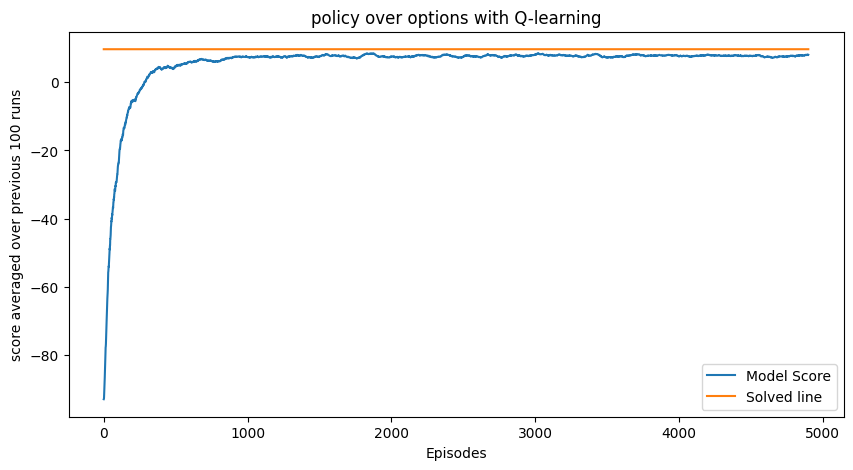

In [10]:
plt.figure(figsize = (10,5))
avg_rews1 = [np.average(rewards1[i:i+100]) for i in range(len(rewards1)-100)]
plt.plot(avg_rews1,label = 'Model Score')
plt.plot([9.7 for i in range(len(avg_rews1))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('policy over options with Q-learning')
plt.legend()

## SMDP learning of policy of selection options, with option policy from Q learning

In [11]:
#### SMDP Q-Learning

rewards2 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}

# Add parameters you might need here
gamma = 0.9
alpha = 0.1

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((env.observation_space.n,nO))
updates_SMDP = np.zeros((env.observation_space.n,nO))

Qopt = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(nO)} #Q-values for each option
eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5
count = 0
Neps = 5000

# Iterate over Neps episodes
for i in range(Neps):
    state = env.reset()
    done = False
    tot_rew = 0
    # While episode is not over
    while not done:

        # Choose action
        x,y,pas,drop = env.decode(state)

        option = egreedy_policy(q_values_SMDP, state, epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
          optact,optdone = Option(env,state,Qopt,option,eps[option])

          [x,y,_,_]=  list(env.decode(state))

          next_state, reward, done,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state))
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          tot_rew+=reward
          reward_surr = reward
          if optdone:
            reward_surr = 20
          if optact<4:
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state
        q_values_SMDP[prev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[prev, option])
        updates_SMDP[prev, option] += 1
    rewards2.append(tot_rew)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

Success (4985/5000) = 99.7%


In [12]:
state = env.reset()
done = False
tot_rew = 0
T = 1
# While episode is not over
while not done:

    # Choose action
    x,y,pas,drop = env.decode(state)
    subState = nDrop*pas+drop
    option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
    eps_main = max(eps_min,eps_decay*eps_main)
    reward_bar = 0
    optdone = False
    move = 0
    prev = state
    while (optdone == False) and not done:


        #--
        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
          # optact = policyOpt[drop][x,y]
          # state, reward, done,_ = env.step(optact)
          # tot_rew += reward
          # x,y,pas,drop = env.decode(state)
          # if x == goal[drop][0] and y==goal[drop][1]:
          #   findDrop = True
          optact,optdone = Option(env,state,Qopt,option,eps[option])

          [x,y,_,_]=  list(env.decode(state))

          next_state, reward, done,_ = env.step(optact)

          clear_output(wait=True)
          print(env.render())
          time.sleep(T)

          [x1,y1,_,_]=  list(env.decode(next_state))

          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          tot_rew+=reward
          reward_surr = reward
          if optdone:
            reward_surr = 20
          if optact<4:
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state

        #--

    _,_,pas,drop = env.decode(state)
    subState = nDrop*pas+drop

    _,_,pas,drop = env.decode(prev)
    subPrev = nDrop*pas+drop

    q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
    updates_SMDP[subPrev, option] += 1
x,y,pas,drop = env.decode(state)


None


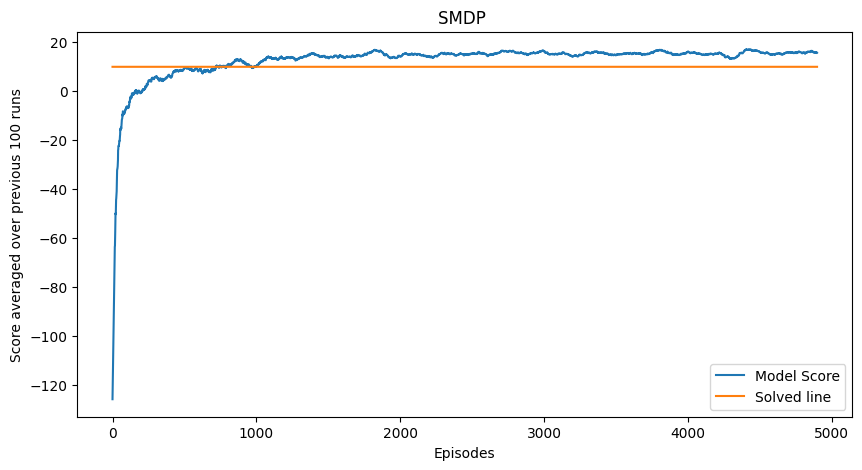

In [14]:
plt.figure(figsize=(10, 5))
avg_rews2 = [np.average(rewards2[i:i + 100]) for i in range(len(rewards2) - 100)]
plt.plot(avg_rews2, label='Model Score')
plt.plot([9.7 for i in range(len(avg_rews2))], label='Solved line')
plt.xlabel('Episodes')
plt.ylabel('Score averaged over previous 100 runs')
plt.title('SMDP ')
plt.legend()
plt.show()

In [16]:
#### SMDP Q-Learning

rewards22 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}





# Add parameters you might need here
gamma = 0.9
alpha = 0.1

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((nPas*nDrop,nO))
updates_SMDP = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(nO)} #Q-values for each option
eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5
count = 0
Neps = 5000

# Iterate over Neps episodes
for i in range(Neps):
    state = env.reset()
    done = False
    tot_rew = 0
    # While episode is not over
    while not done:

        # Choose action
        x,y,pas,drop = env.decode(state)
        subState = nDrop*pas+drop
        option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
          # optact = policyOpt[drop][x,y]
          # state, reward, done,_ = env.step(optact)
          # tot_rew += reward
          # x,y,pas,drop = env.decode(state)
          # if x == goal[drop][0] and y==goal[drop][1]:
          #   findDrop = True
          optact,optdone = Option(env,state,Qopt,option,eps[option])

          [x,y,_,_]=  list(env.decode(state))

          next_state, reward, done,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state))
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          tot_rew+=reward
          reward_surr = reward
          if optdone:
            reward_surr = 20
          if optact<4:
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state



            #--
        _,_,pas,drop = env.decode(state)
        subState = nDrop*pas+drop

        _,_,pas,drop = env.decode(prev)
        subPrev = nDrop*pas+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        updates_SMDP[subPrev, option] += 1
    rewards2.append(tot_rew)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

Success (4979/5000) = 99.58%


Text(0.5, 1.0, 'Policy learnt by SMDP')

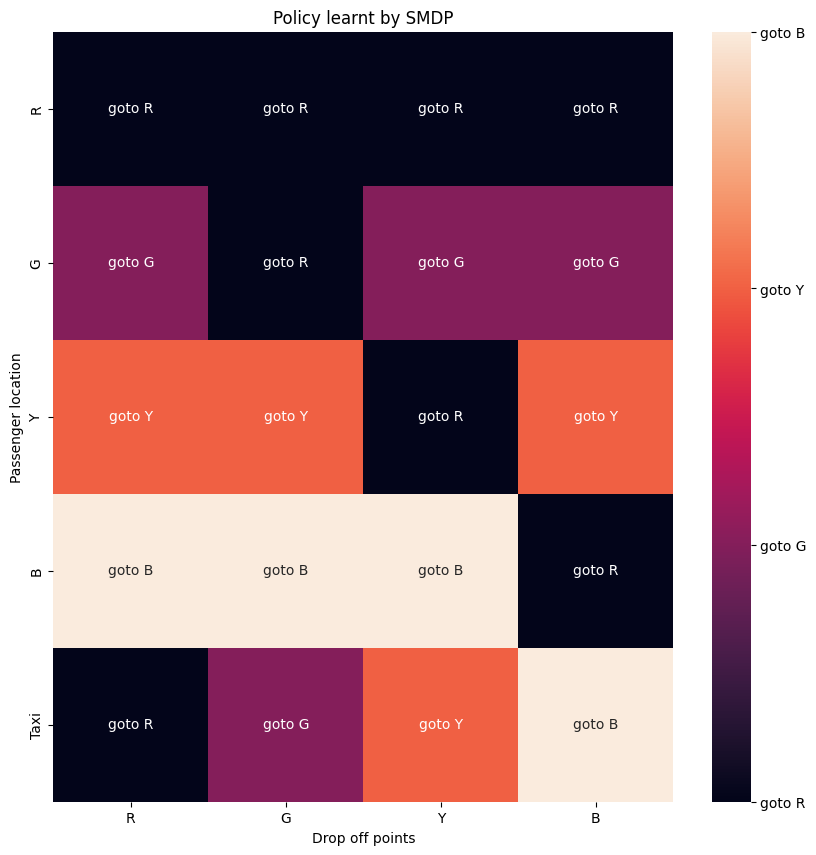

In [17]:
Qmax_SMDP = np.argmax(q_values_SMDP,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by SMDP')

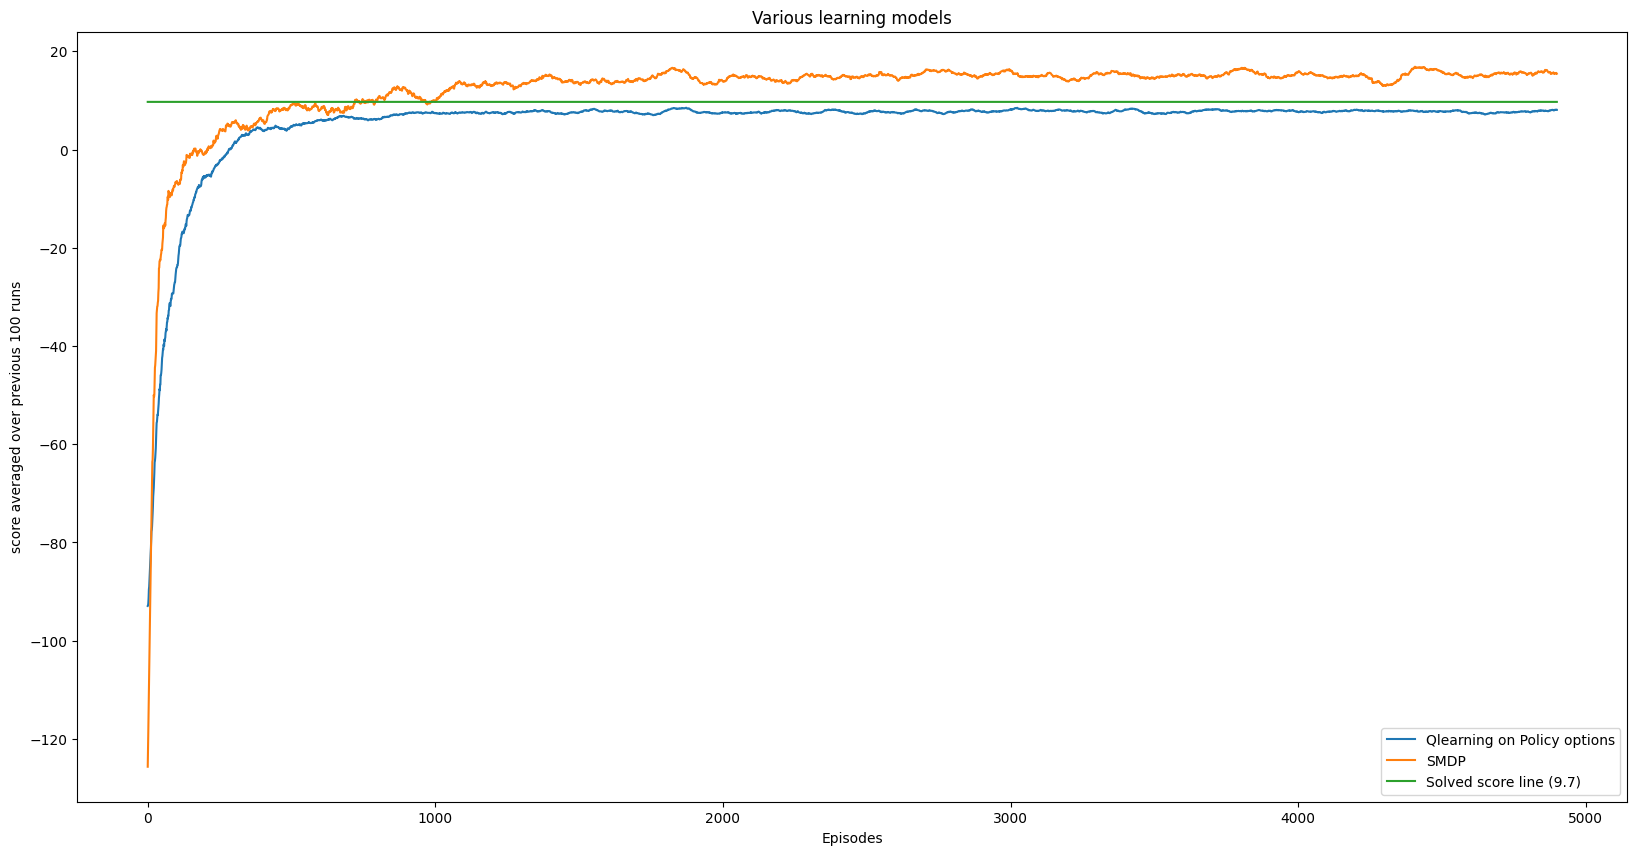

In [18]:
plt.figure(figsize = (20,10))
plt.plot(avg_rews1,label = 'Qlearning on Policy options')
plt.plot(avg_rews2,label = 'SMDP')
plt.plot([9.7 for i in range(len(avg_rews2))],label = 'Solved score line (9.7)')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Various learning models')
plt.legend()

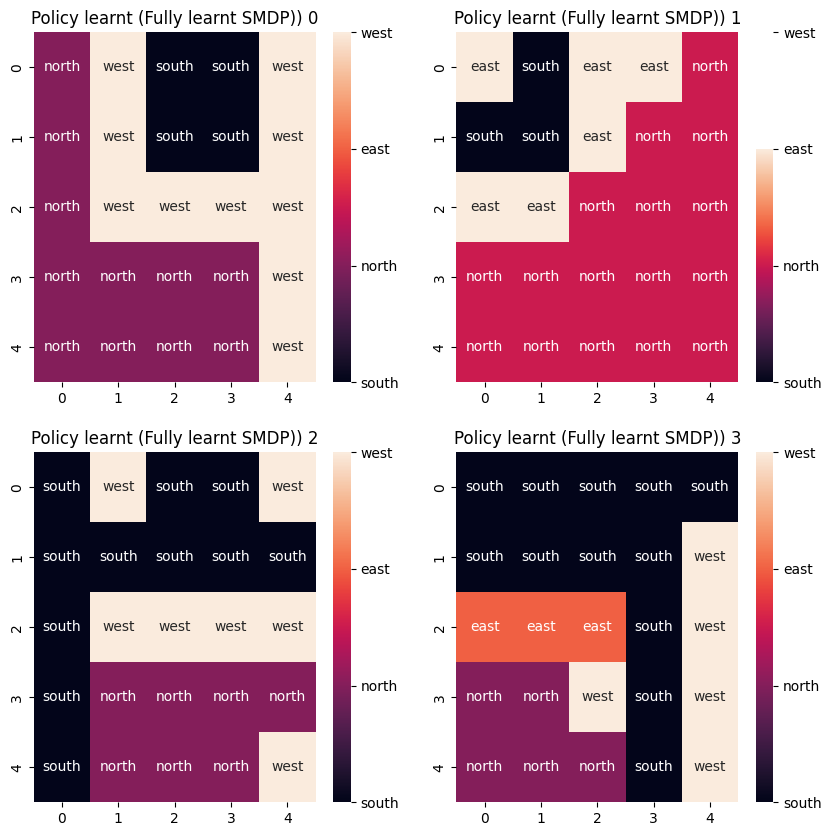

In [19]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (Fully learnt SMDP)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])


## Intra Option Q learning

In [20]:
def Sub(state, nPas = nPas, nDrop = nDrop):
  _,_,pas,drop = env.decode(state)
  subState = nDrop*pas+drop
  return subState

In [23]:
#### Intra Option Q-Learning

rewards3 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}



# Add parameters you might need here
gamma = 0.9
alpha = 0.1

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_IOQL = np.zeros((nPas*nDrop,nO))
updates_IOQL = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(nO)} #Q-values for each option


eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
Neps = 5000

# Iterate over Neps episodes
for i in range(Neps):
    state = env.reset()
    done = False
    tot_rew=0

    # While episode is not over
    while not done:

        # Choose action
        _,_,pas,drop = env.decode(state)
        subState = nDrop*pas+drop
        action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)


        option = action
        optdone = False
        prev = state
        while not optdone and not done:

            # Think about what this function might do?
            optact,optdone = Option(env,state,Qopt,option,eps[option])
            next_state, reward, done,_ = env.step(optact)

            tot_rew+=reward


            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state))
            [x1,y1,_,_]=  list(env.decode(next_state))



            eps[option] = max(eps_min,eps_decay*eps[option])
            tot_rew+=reward
            reward_surr = reward
            if optdone:
              reward_surr = 20
            if optact<4:
              Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])



            #finding all options giving same action call

            for o in range(nO):
              optact_o,optdone_o = Option(env,state,Qopt,o,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o])
                updates_IOQL[Sub(state), o] += 1
            state = next_state

    rewards3.append(tot_rew)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))



Success (4977/5000) = 99.54%


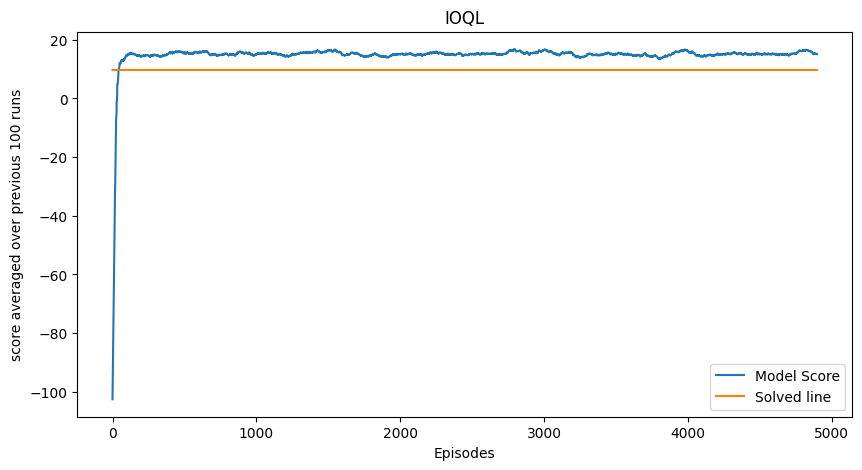

In [26]:
plt.figure(figsize = (10,5))
avg_rews3 = [np.average(rewards3[i:i+100]) for i in range(len(rewards3)-100)]
plt.plot(avg_rews3,label = 'Model Score')
plt.plot([9.7 for i in range(len(avg_rews3))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('IOQL')
plt.legend()

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (4).

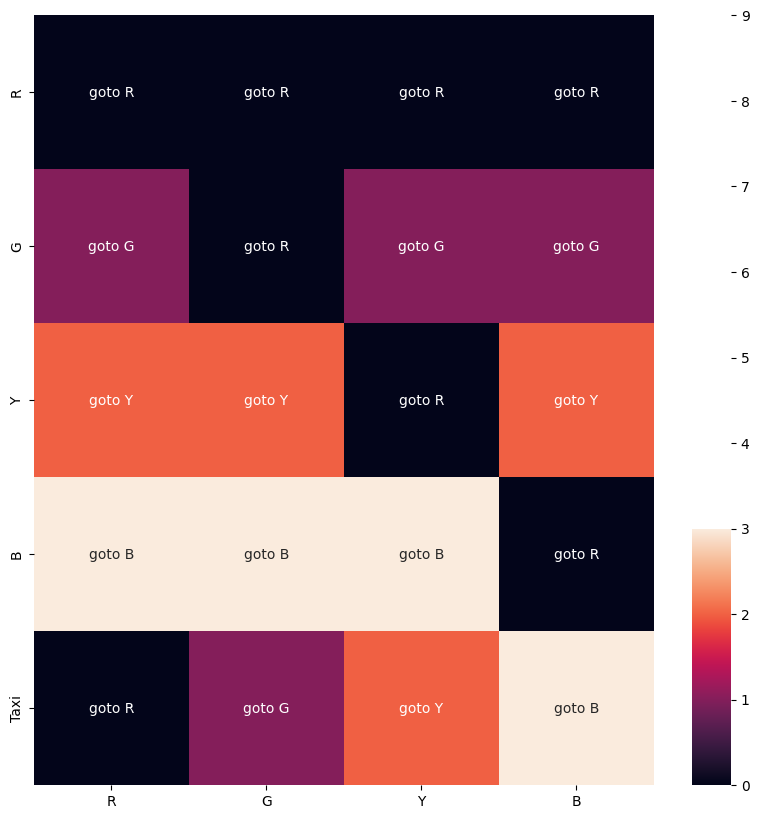

In [27]:
Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_IOQL)

figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text, fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(10)])

c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
#c_bar.set_ticklabels(['south','north','east','west','pick up','drop'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy over default actions learnt by Intra Options')

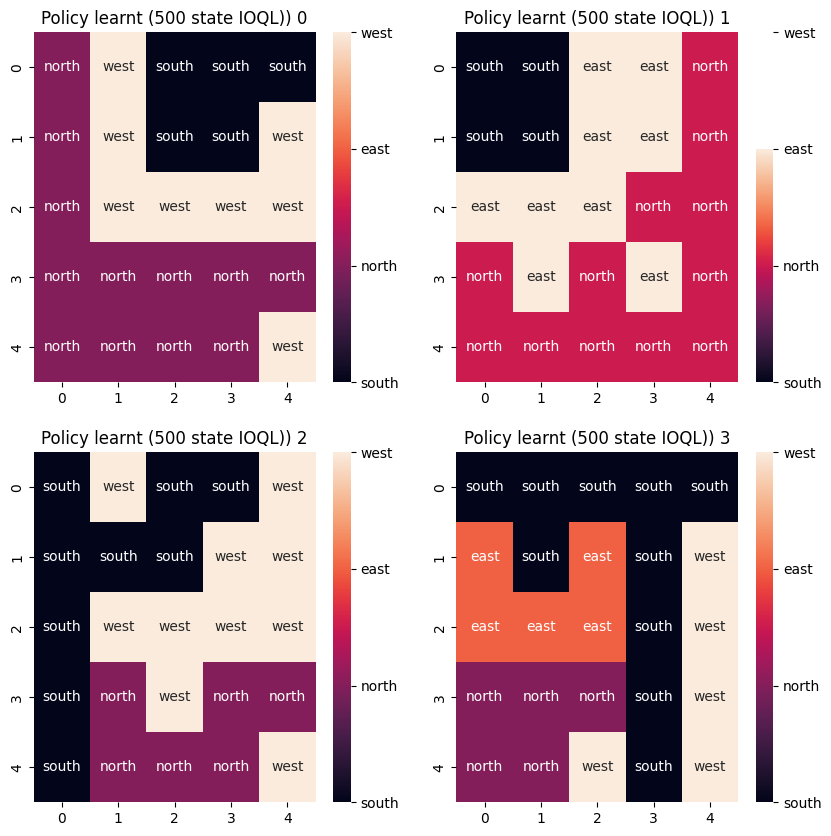

In [ ]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (500 state IOQL)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

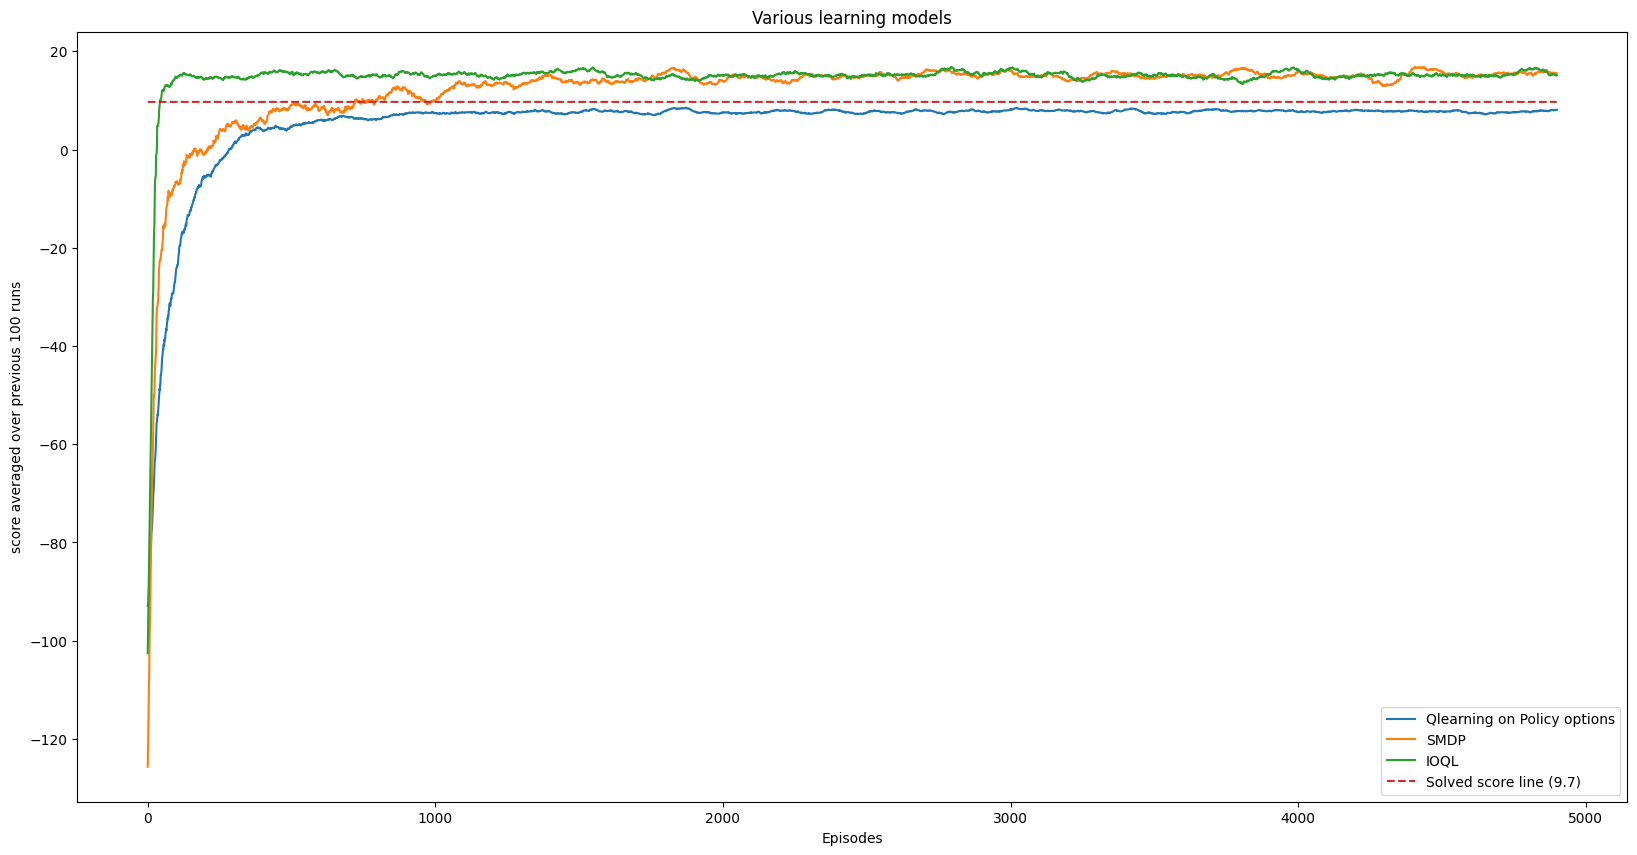

In [28]:
avg_rews4 = [np.average(rewards3[i:i+100]) for i in range(len(rewards3)-100)]

plt.figure(figsize = (20,10))
plt.plot(avg_rews1,label = 'Qlearning on Policy options')
plt.plot(avg_rews2,label = 'SMDP')
plt.plot(avg_rews3,label = 'IOQL')
plt.plot([9.7 for i in range(len(avg_rews2))],'--',label = 'Solved score line (9.7)')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Various learning models')
plt.legend()

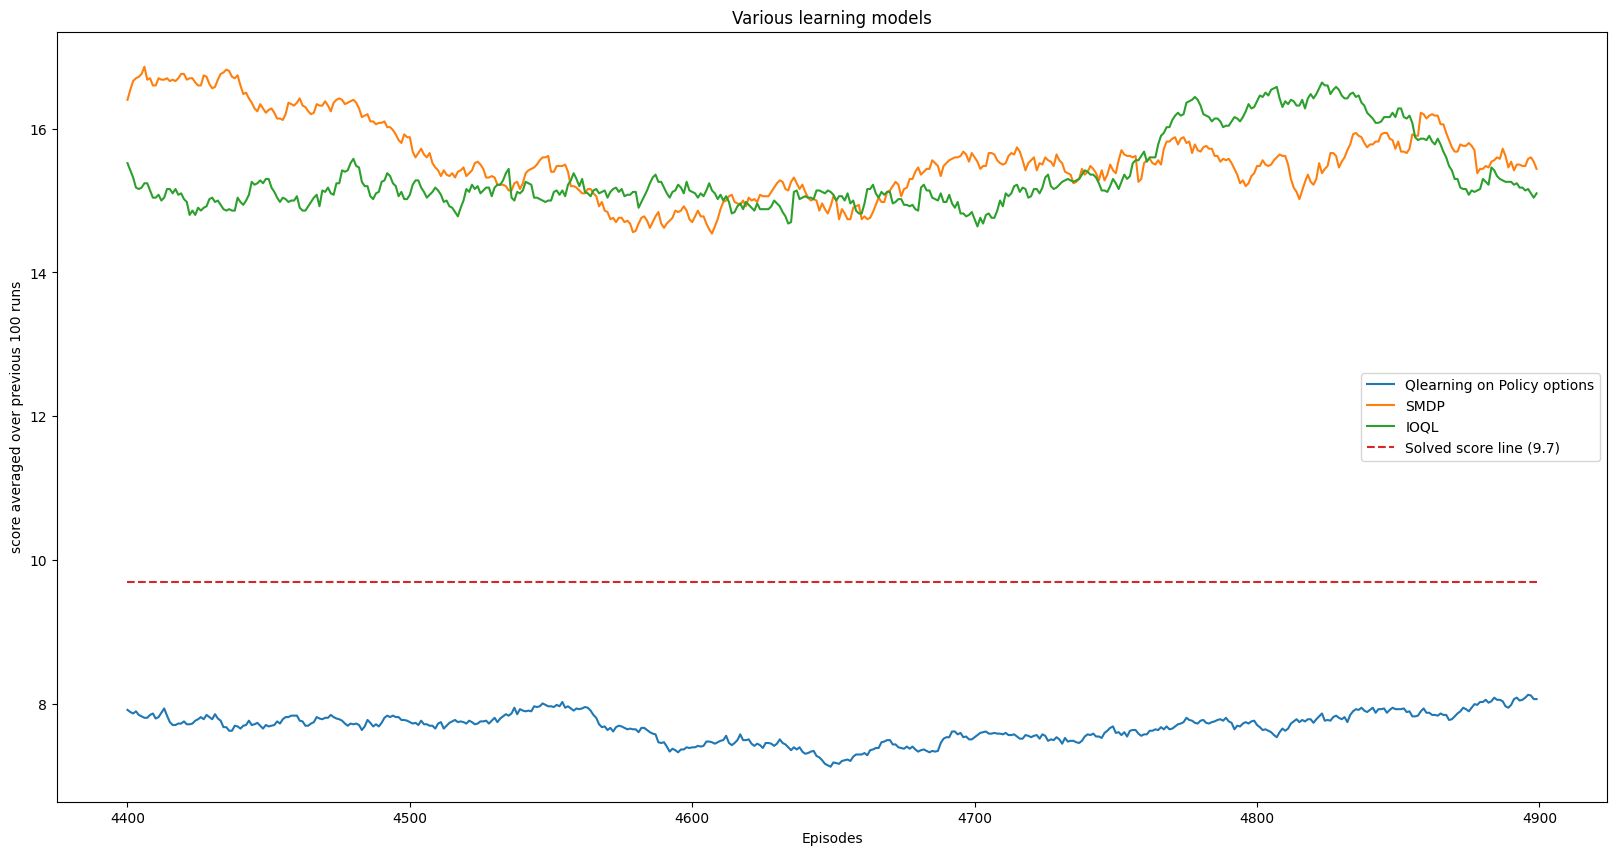

In [31]:
plt.figure(figsize = (20,10))
X = [i for i in range(len(avg_rews1)-500,len(avg_rews1))]
plt.plot(X,avg_rews1[-500:],label = 'Qlearning on Policy options')
plt.plot(X,avg_rews2[-500:],label = 'SMDP')
plt.plot(X,avg_rews3[-500:],label = 'IOQL')
plt.plot(X,[9.7 for i in range(500)],'--',label = 'Solved score line (9.7)')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Various learning models')
plt.legend()

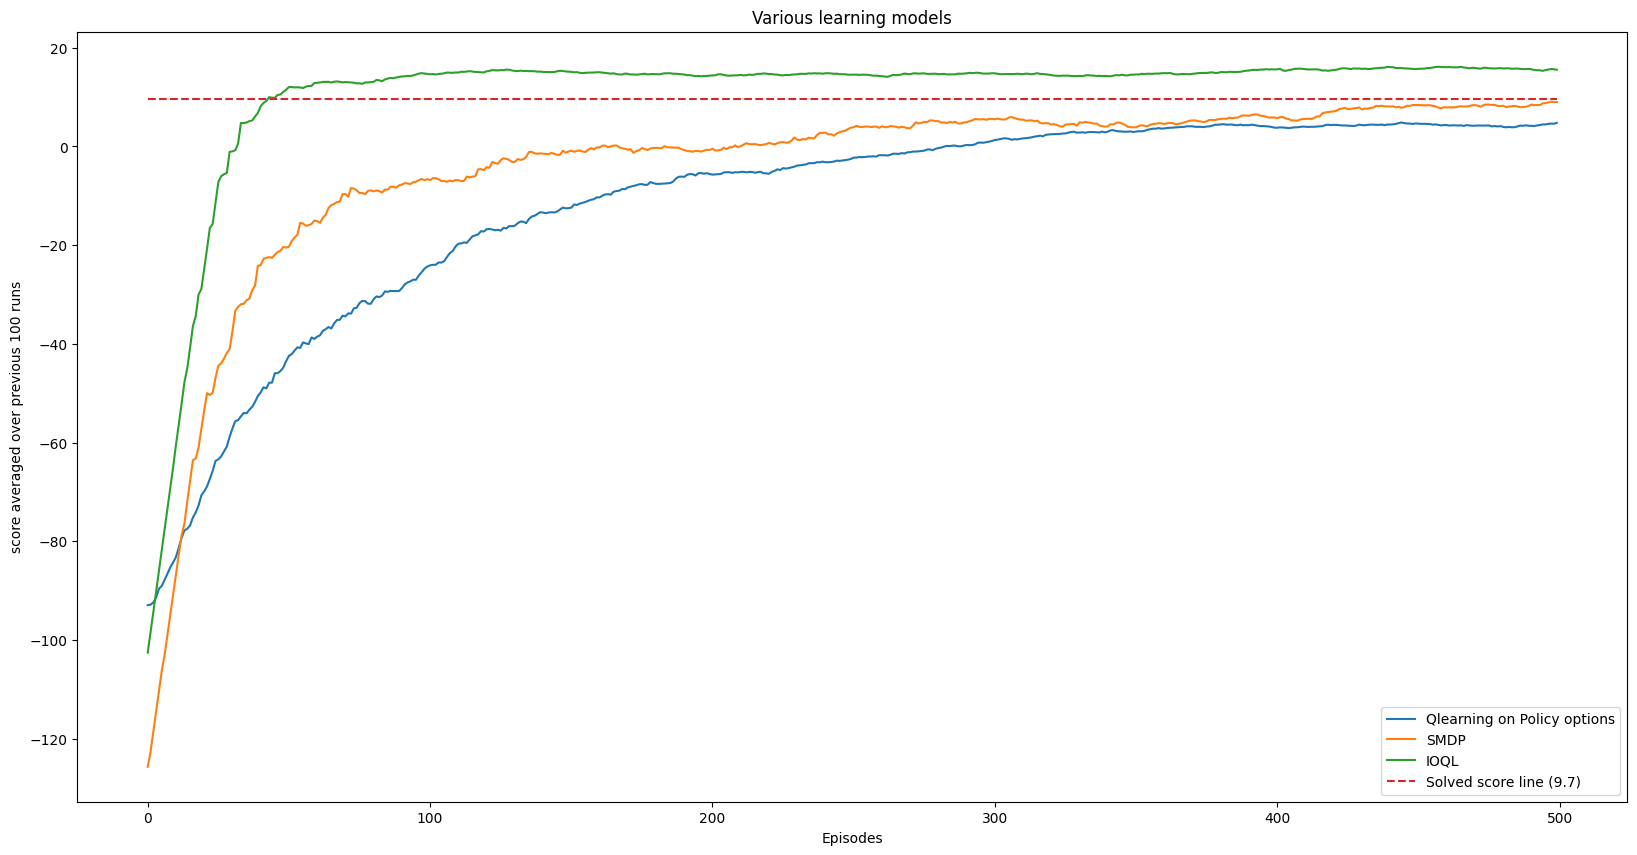

In [32]:
plt.figure(figsize = (20,10))
X = [i for i in range(500)]
plt.plot(X,avg_rews1[:500],label = 'Qlearning on Policy options')
plt.plot(X,avg_rews2[:500],label = 'SMDP')
plt.plot(X,avg_rews3[:500],label = 'IOQL')
plt.plot(X,[9.7 for i in range(500)],'--',label = 'Solved score line (9.7)')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Various learning models')
plt.legend()

Alternate Options:

In [ ]:
box_center = [(2, 2)]
box_edges = [(x, y) for x in range(5) for y in range(5) if x == 0 or x == 4 or y == 0 or y == 4]
box_borders = [(0, y) for y in range(1, 4)] + [(4, y) for y in range(1, 4)] + [(x, 0) for x in range(1, 4)] + [(x, 4) for x in range(1, 4)]

def alternative_policy(env, state, q_values, option, epsilon=0.1):
    x, y, passenger, dropoff = env.decode(state)
    option_done = False
    option_action = 1 # Initialize option_action

    if option == 0 and (x, y) in box_center:
        option_done = True
    elif option == 1 and (x, y) in box_edges:
        option_done = True
    elif option == 2 and (x, y) in box_borders:
        option_done = True
    elif option == 3:
        option_done = True
    else:
        option_done = False

    if not option_done:
        option_action = egreedy_policy(q_values[option], 5*x + y, epsilon=epsilon)

    else:
        if passenger == 4:
            option_action = 5
        elif (x, y) == box_center[0]:
            option_action = random.choice([0, 1, 2, 3])
        else:
            option_action = 4

    return [option_action, option_done]

